In [53]:
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *

from qiskit import IBMQ
IBMQ.load_account()
IBMQ.providers()

ibmqfactory.load_account:WARNING:2022-10-26 00:18:48,431: Credentials are already in use. The existing account in the session will be replaced.


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-nus', group='default', project='default')>]

In [54]:
provider = IBMQ.get_provider(hub='ibm-q-nus', group='default', project='default')
print(provider.backends()) # This will list the available backends, these can also be seen under Compute Resources in the main sidebar

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-nus', group='default', project='default')>, <IBMQBackend('ibmq_montreal') from IBMQ(hub='ibm-q-nus', group='default', project='default')>, <IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-nus', group='default', project='default')>, <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-nus', group='default', project='default')>, <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-nus', group='default', project='default')>, <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-nus', group='default', project='default')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-nus', group='default', project='default')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-nus', group='default', project='default')>, <IBMQBackend('ibmq_guadalupe') from IBMQ(hub='ibm-q-nus', group='default', project='default')>, <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-nus', group='default', project='default')>, <IBMQSimulator('simulator_mps') from IBMQ(hu

In [55]:
backend = provider.get_backend('ibm_hanoi') # replace the name with the exact one for the backend that is desired from the previous displayed backends

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"
# Verifies whether Pulse is supported

In [56]:
backend_config = backend.configuration()
backend_defaults = backend.defaults()

In [57]:
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

# samples need to be multiples of 16 to accommodate the hardware limitations
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

# process the reflective measurement results
# in a reflective measurement the data is encoded in the phase of the output signal
def process_reflective_measurement(freqs, values):
    phase_grad = np.gradient(savgol_filter(np.unwrap(np.angle(values)), 3, 2), freqs)
    return (phase_grad-min(phase_grad))/(max(phase_grad)-min(phase_grad)) - 1

# lorentzian function
def lorentzian(f, f0, k, a, offs):
    return -a*k/(2*np.pi)/((k/2)**2+(f-f0)**2)+offs

#fit_lorentzian takes two arrays that contain the frequencies and experimental output values of each frequency respectively. 
#returns the lorentzian parameters that best fits this output of the experiment.
#popt are the fit parameters and pcov is the covariance matrix for the fit
def fit_lorentzian(freqs, values):
    p0=[freqs[np.argmin(values)], (freqs[-1]-freqs[0])/2, min(values), 0]
    bounds=([freqs[0], 0, -np.inf, -np.inf], [freqs[-1], freqs[-1]-freqs[0], np.inf, np.inf])
    popt, pcov=curve_fit(lorentzian, freqs, values, p0=p0, bounds=bounds)
    return popt, pcov

# exponential function
def exponential(t, tau, a, offset):
    return a*np.exp(-t/tau)+offset

# fit an exponential function
def fit_exponential(ts, values):
    p0=[np.average(ts), 1, 0]
    return curve_fit(exponential, ts, values, p0=p0)

In [58]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play, Acquire
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
import numpy as np

qubit=0   # qubit used in our experiment

readout_time = 4e-6
readout_sigma = 10e-9 

# readout output signal acquisition setup
acquisition_time = readout_time   # We want to acquire the readout signal for the full duration of the readout

In [59]:
center_freq = backend_defaults.meas_freq_est[qubit]  # an estimate for the resonator frequency
freq_span = 0.3e6 # resonator scan span. The span should be larger than the resonator linewidth kappa

frequencies_range = np.linspace(center_freq-freq_span/2, center_freq+freq_span/2, 41)

In [60]:
# build the pulse sequence for low power resonator spectroscopy
freq = Parameter('freq')
amp = Parameter('amp')
with pulse.build(backend=backend, name='readout_cavity_spectroscopy') as meas_spect_sched:
    acq_chan = pulse.acquire_channel(qubit)
    meas_chan = pulse.measure_channel(qubit)
    pulse.set_frequency(freq, meas_chan)
    # We use a square pulse with a Guassian rise and fall time
    duration = get_closest_multiple_of_16(pulse.seconds_to_samples(readout_time))
    sigma = get_closest_multiple_of_16(pulse.seconds_to_samples(readout_sigma))
    width = get_closest_multiple_of_16(pulse.seconds_to_samples(readout_time-8*readout_sigma))
    #drive the resonator
    pulse.play(pulse.GaussianSquare(duration = duration,
                                    amp = amp,
                                    sigma = sigma,
                                    width = width,
                                    name = 'readout tone'), meas_chan)
    #acquire the readout signal
    pulse.acquire(duration = get_closest_multiple_of_16(pulse.seconds_to_samples(acquisition_time)),
                  qubit_or_channel = acq_chan,
                  register = pulse.MemorySlot(qubit))

In [61]:
low_power_schedules = [meas_spect_sched.assign_parameters({freq: f, amp: .3}, inplace=False) for f in frequencies_range]

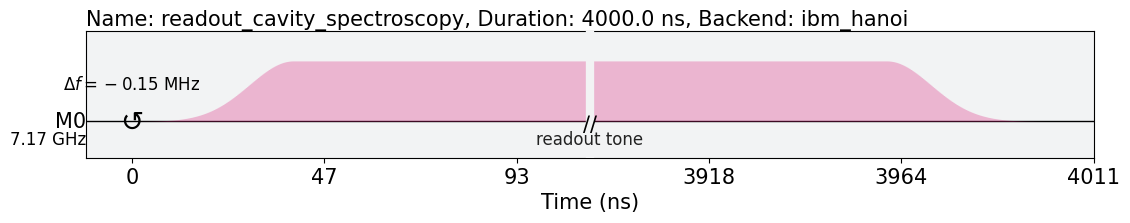

In [62]:
low_power_schedules[0].draw(backend=backend)

In [63]:
#from qiskit import assemble
from qiskit.tools.monitor import job_monitor

num_shots_per_frequency = 2*1024

job_low_power = backend.run(low_power_schedules, 
                            meas_level=1, 
                            meas_return='avg', 
                            shots=num_shots_per_frequency)
job_monitor(job_low_power)

low_power_sweep_results = job_low_power.result(timeout=120)

Job Status: job has successfully run


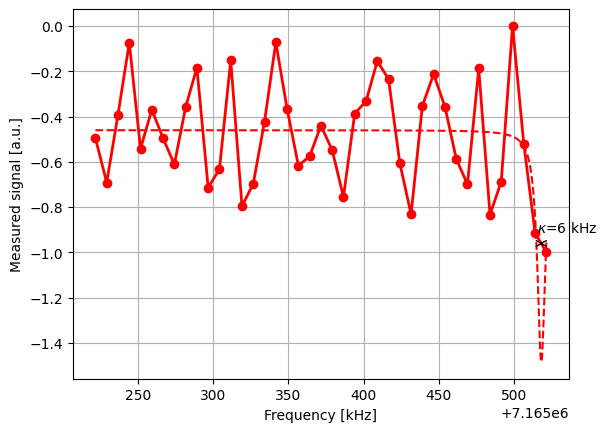

In [64]:
import matplotlib.pyplot as plt

low_power_sweep_values = []
for i in range(len(low_power_sweep_results.results)):
    res_low_power = low_power_sweep_results.get_memory(i)
    low_power_sweep_values.append(res_low_power[qubit])

low_power_sweep_values = process_reflective_measurement(frequencies_range, low_power_sweep_values)

plt.plot(frequencies_range/1e3, low_power_sweep_values, '-o', color='red', lw=2)

popt_low_power, _=fit_lorentzian(frequencies_range, low_power_sweep_values)

popt_low_power, _=fit_lorentzian(frequencies_range, low_power_sweep_values)
f0, kappa, a, offset = popt_low_power

fs=np.linspace(frequencies_range[0], frequencies_range[-1], 1000)
plt.plot(fs/1e3, lorentzian(fs, *popt_low_power), color='red', ls='--')
plt.annotate("", xy=((f0-kappa/2)/1e3, offset-1/2), xytext=((f0+kappa/2)/1e3, offset-1/2), arrowprops=dict(arrowstyle="<->", color='black'))
plt.annotate("$\kappa$={:d} kHz".format(int(kappa/1e3)), xy=((f0-kappa/2)/1e3, offset-.45), color='black')

plt.grid()
plt.xlabel("Frequency [kHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

# Measuring Kai and G

In [65]:
schedule_frequencies = [meas_spect_sched.assign_parameters({freq: f, amp: 1}, inplace=False) for f in frequencies_range]

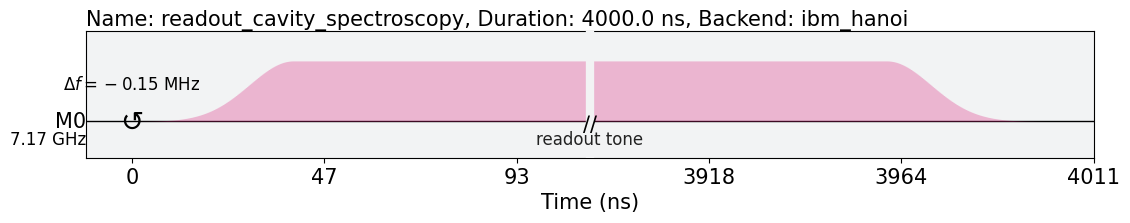

In [66]:
schedule_frequencies[0].draw(backend=backend)

In [67]:
frequency_sweep_high_power = backend.run(schedule_frequencies, 
                                         meas_level=1, 
                                         meas_return='avg', 
                                         shots=num_shots_per_frequency)

job_monitor(frequency_sweep_high_power)

high_power_sweep_results = frequency_sweep_high_power.result(timeout=120)

Job Status: job has successfully run


In [68]:
high_power_sweep_values = []
for i in range(len(high_power_sweep_results.results)):
    res_high_power = high_power_sweep_results.get_memory(i)
    high_power_sweep_values.append(res_high_power[qubit])

high_power_sweep_values = process_reflective_measurement(frequencies_range, high_power_sweep_values)

popt_high_power, _=fit_lorentzian(frequencies_range, high_power_sweep_values)

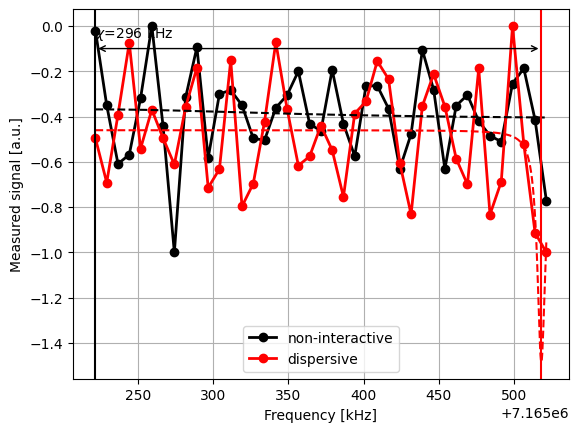

chi=296.7 kHz
g=25.1 MHz


In [69]:
plt.plot(frequencies_range/1e3, high_power_sweep_values, '-o', color='black', lw=2, label='non-interactive')
plt.plot(frequencies_range/1e3, low_power_sweep_values, '-o', color='red', lw=2, label='dispersive')

fs=np.linspace(frequencies_range[0], frequencies_range[-1],1000)
plt.plot(fs/1e3, lorentzian(fs, *popt_high_power), color='black', ls='--')
plt.plot(fs/1e3, lorentzian(fs, *popt_low_power), color='red', ls='--')

plt.axvline(x=popt_low_power[0]/1e3, color='red')
plt.axvline(x=popt_high_power[0]/1e3, color='black')

chi=popt_low_power[0]-popt_high_power[0]
plt.annotate("", xy=(popt_low_power[0]/1e3, -.1), xytext=(popt_high_power[0]/1e3, -.1), arrowprops=dict(arrowstyle="<->", color='black'))
plt.annotate("$\chi$={:d} kHz".format(int(chi/1e3)), xy=(popt_high_power[0]/1e3, -.05), color='black')

plt.grid()
plt.xlabel("Frequency [kHz]")
plt.ylabel("Measured signal [a.u.]")
plt.legend()
plt.show()

print(r'chi={:.1f} kHz'.format((popt_low_power[0]-popt_high_power[0])/1e3))
Delta=abs(backend_defaults.meas_freq_est[qubit] - backend_defaults.qubit_freq_est[qubit])
print(r'g={:.1f} MHz'.format(np.sqrt(chi*Delta)/1e6))

In [70]:
drive_sigma = 100e-9
drive_duration = 8*drive_sigma

# We drive our qubit, wait for some time (time delay), and then measure the qubit
# Using these measurements we can create a plot of qubit population vs. time delay
delay_times=np.linspace(0, 600e-6, 61) #measurement time delays
qubit_decay_pulses = []
for delay in delay_times:
    with pulse.build(backend=backend, default_alignment='sequential', name=f"decay delay = {delay * 1e6} us") as temp_decay_pulse:
        drive_chan = pulse.drive_channel(qubit)
        meas_chan = pulse.measure_channel(qubit)
        acq_chan = pulse.acquire_channel(qubit)

        #drive the qubit
        pulse.play(pulse.Gaussian(duration=get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration)),
                                  amp=.5,
                                  sigma=get_closest_multiple_of_16(pulse.seconds_to_samples(drive_sigma)),
                                  name='qubit tone'), drive_chan)
        #wait for the duration of the time delay before measuring the qubit
        pulse.delay(get_closest_multiple_of_16(pulse.seconds_to_samples(delay)), meas_chan)
                
        with pulse.align_left():
            duration = get_closest_multiple_of_16(pulse.seconds_to_samples(readout_time))
            sigma = get_closest_multiple_of_16(pulse.seconds_to_samples(readout_sigma))
            width = get_closest_multiple_of_16(pulse.seconds_to_samples(readout_time-8*readout_sigma))
            #drive the resonator with low power
            pulse.play(pulse.GaussianSquare(duration = duration,
                                            amp = .3,
                                            sigma = sigma,
                                            width = width,
                                            name = 'low power readout tone'), meas_chan)
            #acquire the readout signal
            pulse.acquire(duration = get_closest_multiple_of_16(pulse.seconds_to_samples(acquisition_time)),
                          qubit_or_channel = acq_chan,
                          register = pulse.MemorySlot(qubit))
        
    qubit_decay_pulses.append(temp_decay_pulse)

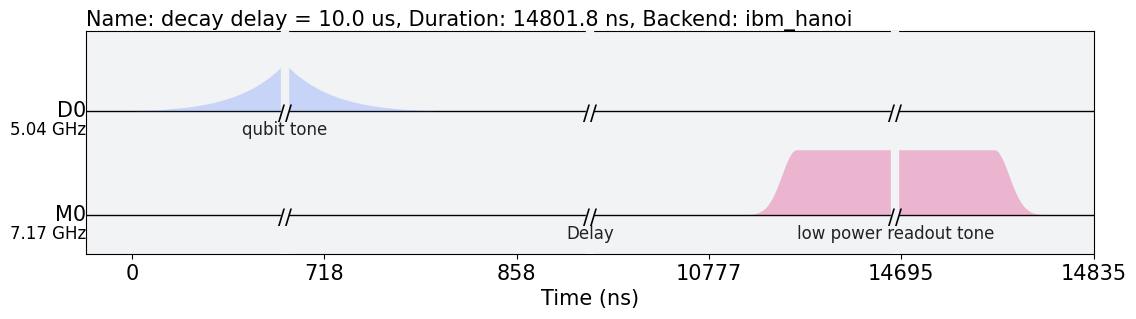

In [71]:
qubit_decay_pulses[1].draw(backend=backend)

In [72]:
num_shots = 4*1024  # increasing this number will make your output more accurate,
                    # but it will slow down the experiment

job_qubit_decay = backend.run(qubit_decay_pulses, 
                              meas_level=1, 
                              meas_return='avg', 
                              shots=num_shots)

job_monitor(job_qubit_decay)

Job Status: job has successfully run


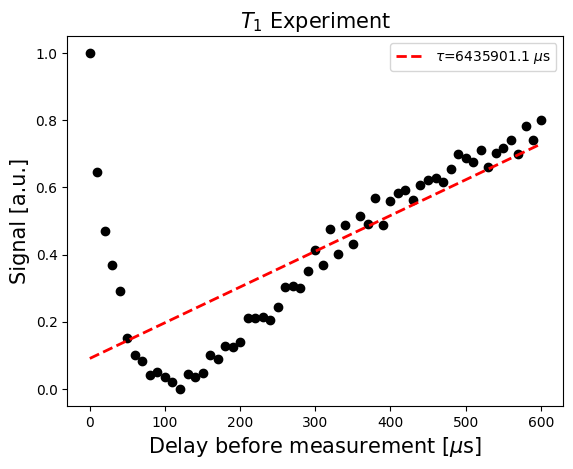

gamma=  0.00 kHz


In [73]:
qubit_decay_results = job_qubit_decay.result(timeout=120)

qubit_decay_values = []
for i in range(len(delay_times)):
    qubit_decay_values.append(qubit_decay_results.get_memory(i)[qubit])
qubit_decay_values = np.abs(qubit_decay_values)
qubit_decay_values = (qubit_decay_values-min(qubit_decay_values))
qubit_decay_values/=max(qubit_decay_values)

decay_popt, _=fit_exponential(delay_times, qubit_decay_values)
tau=decay_popt[0]
g=1/tau

plt.scatter(delay_times*1e6, qubit_decay_values, color='black') 
plt.plot(delay_times*1e6, exponential(delay_times, *decay_popt), '--', lw=2, color='red', label=r'$\tau$={:.1f} $\mu$s'.format(tau*1e6))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

print(r'gamma=  {:.2f} kHz'.format(g/1e3))

# Measuring the Qubit ac-Stark shift

In [74]:
dt=backend_config.dt  # hardware resolution
backend.configuration().parametric_pulses = [] # will allow us to send a larger waveform for our experiments

In [75]:
from scipy.optimize import leastsq,minimize, curve_fit

# samples need to be multiples of 16 to accommodate the hardware limitations
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

# lorentzian function
def lorentzian(f, f0, k, a, offs):
    return a*k/(2*np.pi)/((k/2)**2+(f-f0)**2)+offs

#fit_lorentzian takes two arrays that contain the frequencies and experimental output values of each frequency respectively. 
#returns the lorentzian parameters that best fits this output of the experiment.
#popt are the fit parameters and pcov is the covariance matrix for the fit
def fit_lorentzian(freqs,values):
    p0=[freqs[np.argmax(values)],(freqs[-1]-freqs[0])/2,max(values),0]
    bounds=([freqs[0],0,0,-np.inf],[freqs[-1],freqs[-1]-freqs[0],np.inf,np.inf])
    popt,pcov=curve_fit(lorentzian, freqs, values, p0=p0, bounds=bounds)
    return popt,pcov

# Gaussian function
def gaussian(f, f0, sigma, a, offs):
    return a*np.exp(-(f-f0)**2/(2*sigma**2))+offs

#fit_gaussian takes two arrays that contain the frequencies and experimental output values of each frequency respectively. 
#returns the gaussian parameters that best fits this output of the experiment.
#popt are the fit parameters and pcov is the covariance matrix for the fit
def fit_gaussian(freqs,values):
    p0=[freqs[np.argmax(values)],(freqs[-1]-freqs[0])/2,max(values),0]
    bounds=([freqs[0],0,0,-np.inf],[freqs[-1],freqs[-1]-freqs[0],np.inf,np.inf])
    popt,pcov=curve_fit(gaussian, freqs, values, p0=p0, bounds=bounds)
    return popt,pcov

# normalize the data points to fall in the range of [0,1]
def normalize(a):
    a= a-min(a)
    return a/max(a)

In [76]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play, Acquire
import qiskit.pulse.library as pulse_lib
import numpy as np

qubit=0   # qubit used in our experiment

inst_sched_map = backend_defaults.instruction_schedule_map
# Get the default measurement pulse sequence
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[0])  

qubit_drive_sigma = 100e-9           #the width of the qubit spectroscopy drive
resonator_drive_sigma=10e-9          #the width of the resonator drive
drive_duration=10*qubit_drive_sigma  #the resonator drive duration

# We use a Gaussian shape pulse to drive the qubit for spectroscopy
qubit_drive = pulse_lib.gaussian(duration = get_closest_multiple_of_16(drive_duration//dt),
                             amp = .1,
                             sigma = get_closest_multiple_of_16(qubit_drive_sigma//dt),
                             name = 'qubit tone')


drive_chan = pulse.DriveChannel(qubit)   # qubit drive channel
meas_chan = pulse.MeasureChannel(qubit)  # resonator channel
acq_chan = pulse.AcquireChannel(qubit)   # readout signal acquisition channel

In [77]:
measurement_delay=20e-9*3

resonator_tone_amplitude = np.linspace(0,1,11) #change to amplitude
resonator_tone_pulses = []
for amp in resonator_tone_amplitude:
    # we use a square pulse with Gaussian rise and fall time to populate the resonator with photons
    temp_resonator_tone=pulse_lib.GaussianSquare(duration = get_closest_multiple_of_16(drive_duration//dt),
                             amp = amp,
                             sigma = get_closest_multiple_of_16(resonator_drive_sigma//dt),
                             width = get_closest_multiple_of_16((drive_duration-4*resonator_drive_sigma)//dt),
                             name = 'resonator tone')
    # pulse sequence for the experiment at different amplitudes
    with pulse.build(name=f"resonator tone amplitude = {np.round(amp,2)} V") as temp_pulse:
        pulse.play(qubit_drive, drive_chan)
        pulse.play(temp_resonator_tone, meas_chan)
        pulse.delay(get_closest_multiple_of_16(measurement_delay//dt), meas_chan)
        pulse.call(measure)
    
    resonator_tone_pulses.append(temp_pulse)

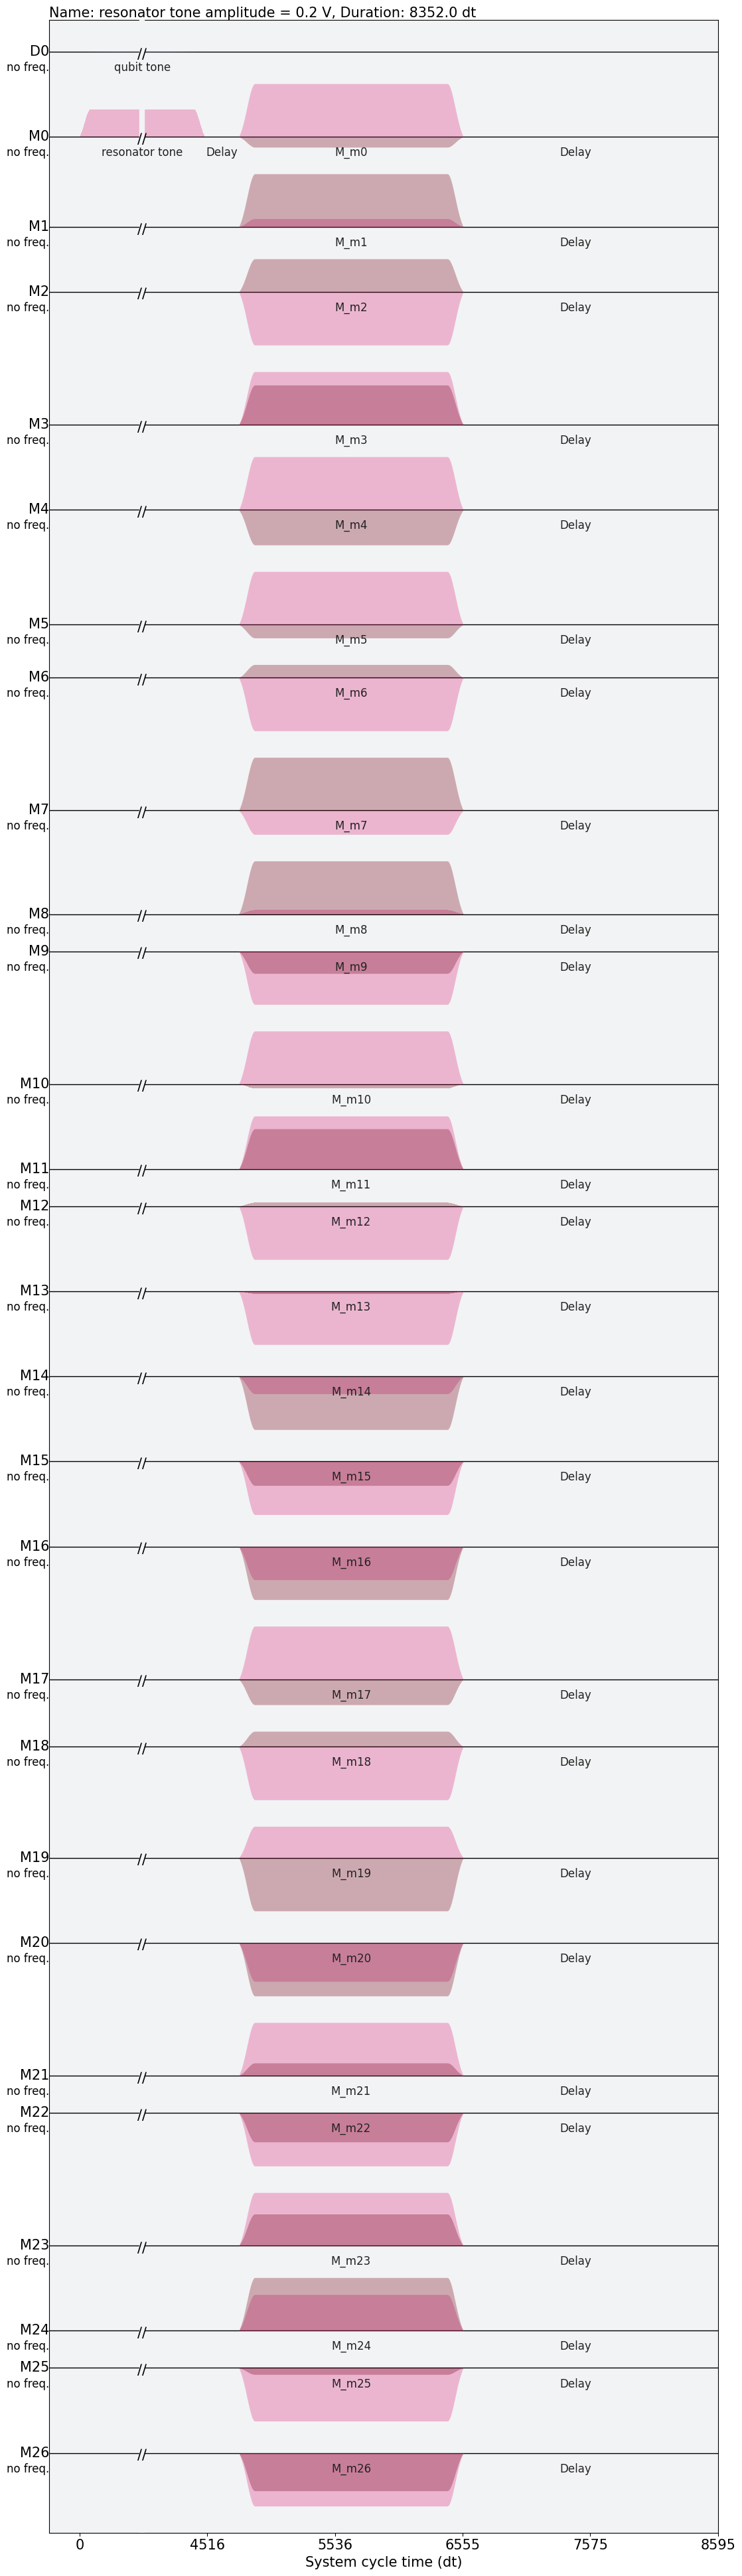

In [78]:
resonator_tone_pulses[2].draw()

In [79]:
start=4.960e9  # qubit spectroscopy start frequency
stop=4.980e9   # qubit spectroscopy stop frequency
freqs = np.linspace(start, stop, 41)-500e3
# list of qubit drive frequencies for spectroscopy
schedule_frequencies = [{drive_chan: freq , meas_chan: backend_defaults.meas_freq_est[qubit]} for freq in freqs]

In [80]:
num_shots = 4*1024

resonator_tone_experiments=[(resonator_tone_pulses[i],
                            {'meas_level':  1,
                             'meas_return': 'avg',
                             'shots':        num_shots,
                             'schedule_los': schedule_frequencies}) for i in range(len(resonator_tone_pulses))]

resonator_tone_results=[]
for experiment, args in resonator_tone_experiments:
    job = backend.run(experiment, **args)
    job_monitor(job)
    resonator_tone_results.append(job.result(timeout=120))

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


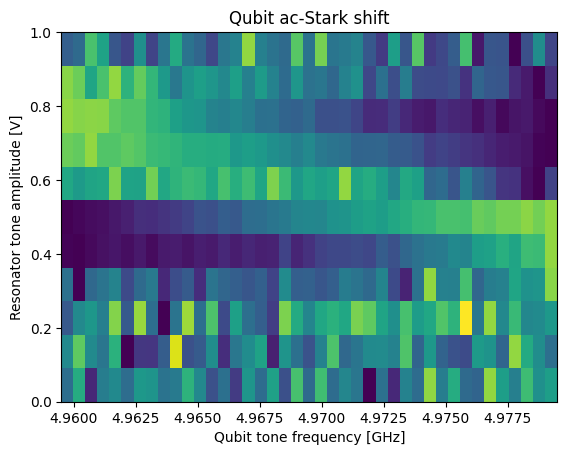

In [83]:
import matplotlib.pyplot as plt

skip_idx=0

resonator_tone_values = []
for result in resonator_tone_results:
    result_values=[]
    for i in range(len(result.results)):
        result_values.append(result.get_memory(i)[qubit])

    resonator_tone_values.append(normalize(result_values))
    
plot_extent=[freqs[0]/1e9,freqs[-1]/1e9,resonator_tone_amplitude[skip_idx],resonator_tone_amplitude[-1] ]
plt.imshow(np.abs(resonator_tone_values[skip_idx:]), aspect='auto', origin='lower', cmap='viridis',
          extent=plot_extent)

plt.xlabel('Qubit tone frequency [GHz]')
plt.ylabel('Resonator tone amplitude [V]')
plt.title('Qubit ac-Stark shift')
plt.show()

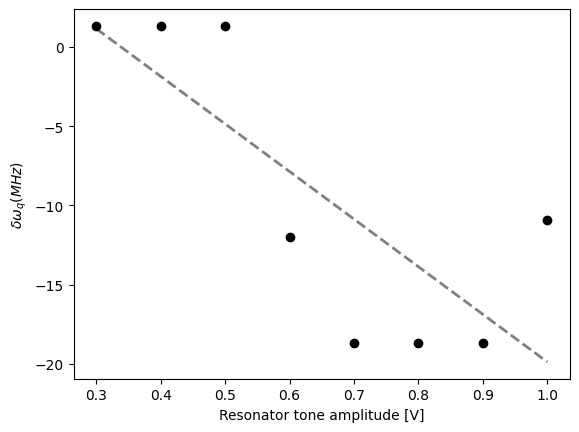

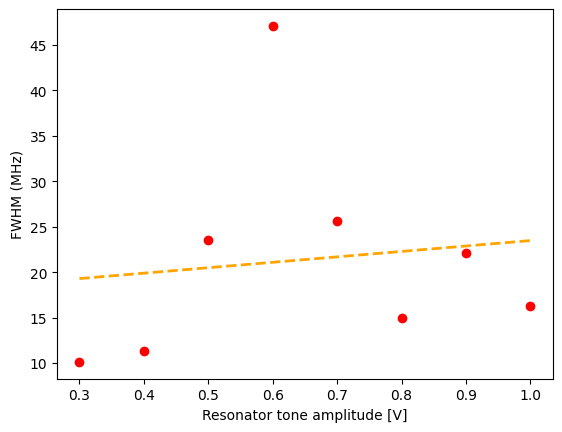

In [84]:
show_individual_traces=False
skip_idx=3  # number of points to skip

center=[]
fwhm=[]
for i in range(len(resonator_tone_values)):
    popt,pcov=fit_gaussian(freqs,np.abs(np.real(resonator_tone_values[i])))
    center.append(popt[0])
    fwhm.append(2.355*popt[1])
    if show_individual_traces:
        plt.plot(freqs/1e3, np.real(resonator_tone_values[i]))
        plt.plot(freqs/1e3, gaussian(freqs,*popt), '--')
if show_individual_traces: plt.show()

center_fit=np.polyfit(resonator_tone_amplitude[skip_idx:], (center[skip_idx:]-center[0]),1)
plt.plot(resonator_tone_amplitude[skip_idx:], np.poly1d(center_fit/1e6)(resonator_tone_amplitude[skip_idx:]), '--', lw=2, color='grey')
plt.plot(resonator_tone_amplitude[skip_idx:], (center[skip_idx:]-center[0])/1e6, 'o', color='black')
plt.xlabel(r'Resonator tone amplitude [V]')
plt.ylabel(r'$\delta \omega_q (MHz)$')
plt.show()

fwhm_fit=np.polyfit(resonator_tone_amplitude[skip_idx:], np.array(fwhm[skip_idx:]),1)
plt.plot(resonator_tone_amplitude[skip_idx:], np.poly1d(fwhm_fit/1e6)(resonator_tone_amplitude[skip_idx:]), '--', lw=2, color='orange')
plt.plot(resonator_tone_amplitude[skip_idx:], np.array(fwhm[skip_idx:])/1e6, 'o', color='red')
plt.xlabel(r'Resonator tone amplitude [V]')
plt.ylabel(r'FWHM (MHz)')
plt.show()